Solve heat equation on 2D domain with Periodic boundary conditions. 
Specify an IC, define OpInf problem and attempt a solution. Check retrieved diffusion operator!

In [51]:
import numpy as np
import pandas as pd
import scipy.linalg as la
import scipy.sparse as sparse
import matplotlib.pyplot as plt

import opinf

In [67]:
import os

In [68]:
fig_save_dir = "./diff_2d_img"

In [69]:
# create numpy array for velocity

In [70]:
nx = 64
ny = 64

In [71]:
alpha = 1e-2

In [72]:
x = np.linspace(0, 1, nx + 1)
y = np.linspace(0, 1, ny + 1)

In [73]:
xm = x[:-1] + (x[1] - x[0]) / 2  # x-Grid (location of cell centers)
ym = y[:-1] + (y[1] - y[0]) / 2  # y-Grid (location of cell centers)

In [74]:
XM, YM = np.meshgrid(xm, ym)

In [75]:
dx = xm[1] - xm[0]
dy = ym[1] - ym[0]

dxi = 1 / dx
dyi = 1 / dy

dxi2 = 1 / dx ** 2
dyi2 = 1 / dy ** 2

In [76]:
u = np.zeros((nx + 1, ny))
v = np.zeros((nx, ny + 1))
for i in range(nx):
    for j in range(ny):
        u[i, j] = 1 / 10 - (np.sin(np.pi * x[i])) ** 2 * (
                    np.sin(np.pi * (ym[j] - 0.05)) * np.cos(np.pi * (ym[j] - 0.05)) -
                    np.sin(np.pi * (ym[j] + 0.05)) * np.cos(np.pi * (ym[j] + 0.05)))
for i in range(nx):
    for j in range(ny):
        v[i, j] = np.sin(np.pi * xm[i]) * np.cos(np.pi * xm[i]) * (
                    (np.sin(np.pi * (y[j] - 0.05))) ** 2 -
                    (np.sin(np.pi * (y[j] + 0.05))) ** 2)

In [77]:
theta_s = 0.01
theta_h = 0.05
theta_x = 0.3
theta_y = 0.55

In [78]:
omega = np.zeros((nx, ny))
for i in range(nx):
    for j in range(ny):
        omega[i, j] = ((theta_s) / (2 * np.pi * theta_h**2)) * (np.exp(-((theta_x - xm[i]) ** 2 + (theta_y - ym[j]) ** 2) / (2 * theta_h ** 2)) 
         - np.exp(-((xm[i] - theta_x + 0.05) ** 2 + (ym[j] - theta_y + 0.05) ** 2) / (2 * theta_h ** 2)))

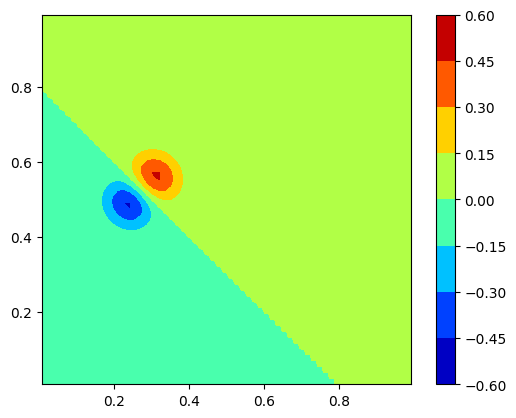

In [79]:
plt.contourf(xm, ym, omega.T,
              origin='lower',
              cmap='jet')
plt.axis('square')
plt.colorbar()

In [80]:
do_calc_phi = 1

In [82]:
if do_calc_phi:
    # # Compute the timestep based on the max CFL and set final time
    CFL = 0.8
    maxU = np.max(np.abs(u))
    maxU = np.max([maxU, np.max(np.abs(v))])
    dt_c = CFL * dx / maxU  # dt based on convective CFL
    dt_v = CFL * dx ** 2 / alpha / 4  # dt based on viscous CFL
    
    dt = min(dt_c, dt_v)   # Simulation timestep
    print("Simulation timestep is ", dt)
    tf = 2.5                 # Final time
    # dt = 0.0005
    # tf = 2
    # Initialize phi
    phi = np.zeros((nx, ny))
    phi_old = phi.copy()
    phi_mid = np.zeros(nx*ny)


    phi_tensor = []
    # Output frequency
    import copy
    # Output frequency
    freq = tf / 8
    otime = copy.deepcopy(freq)
    # Loop through time
    t = 0
    tcount = 0
    while t <= tf:
        # Loop through space
        for i in range(nx):
            for j in range(ny):
                ip1 = i + 1
                if ip1 == nx:
                    ip1 = 0
                
                ip2 = i + 2
                if ip2 == nx:
                    ip2 = 0
                elif ip2 == nx + 1:
                    ip2 = 1
                im1 = i - 1
                if im1 == -1:
                    im1 = nx - 1
                
                im2 = i - 2
                if im2 == -1:
                    im2 = nx - 1
                elif im2 == -2:
                    im2 = nx - 2
                
                jp1 = j + 1
                if jp1 == ny:
                    jp1 = 0
                
                jp2 = j + 2
                if jp2 == ny:
                    jp2 = 0
                elif jp2 == ny + 1:
                    jp2 = 1
                jm1 = j - 1
                if jm1 == -1:
                    jm1 = ny - 1
                jm2 = j - 2
                if jm2 == -1:
                    jm2 = ny - 1
                elif jm2 == -2:
                    jm2 = ny - 2
                # Diffusion (explicit)
                diff = alpha * dxi2 * (phi_old[im1, j] - 2 * phi_old[i, j] + phi_old[ip1, j])  # in x
                diff += alpha * dyi2 * (phi_old[i, jm1] - 2 * phi_old[i, j] + phi_old[i, jp1])  # in y
                
                # Face velocities
                ue = u[i + 1, j]
                uw = u[i, j]
                un = v[i, j + 1]
                us = v[i, j]
                
                # QUICK reconstruction (explicit)
                # E
                if ue > 0:
                    phi_e = (-phi_old[im1, j] + 5 * phi_old[i, j] + 2 * phi_old[ip1, j]) / 6
                else:
                    phi_e = (2 * phi_old[i, j] + 5 * phi_old[ip1, j] - phi_old[ip2, j]) / 6
                # W
                if uw > 0:
                    phi_w = (-phi_old[im2, j] + 5 * phi_old[im1, j] + 2 * phi_old[i, j]) / 6
                else:
                    phi_w = (2 * phi_old[im1, j] + 5 * phi_old[i, j] - phi_old[ip1, j]) / 6
                # N
                if un > 0:
                    phi_n = (-phi_old[i, jm1] + 5 * phi_old[i, j] + 2 * phi_old[i, jp1]) / 6
                else:
                    phi_n = (2 * phi_old[i, j] + 5 * phi_old[i, jp1] - phi_old[i, jp2]) / 6
                # S
                if us > 0:
                    phi_s = (-phi_old[i, jm2] + 5 * phi_old[i, jm1] + 2 * phi_old[i, j]) / 6
                else:
                    phi_s = (2 * phi_old[i, jm1] + 5 * phi_old[i, j] - phi_old[i, jp1]) / 6
                # Convection (explicit)
                conv =      - dxi * (ue*phi_e - uw*phi_w) # in x
                conv = conv - dyi * (un*phi_n - us*phi_s) # in y
                
                # Update
                # 1st-order explicit
                phi[i,j] = phi_old[i,j] + dt * (conv + diff + omega[i,j])
        
        
        # Update time
        t = t + dt
        
        # Update old phi
        phi_old = phi

        phi_tensor.append(phi.T)
        # Plot
        if t>otime:
            plt.figure(1)
            plt.contourf(xm, ym, phi.T,
                        origin='lower',
                        vmin=-0.2,
                        vmax=0.2,
                        cmap='jet'
                        )
            hs = plt.streamplot(XM, YM, u[0:nx, 0:ny], v[0:nx, 0:ny])
            # hs.set_color('w')
            # hs.set_linewidth(1)
            plt.axis('square')
            title_text = 'Time: ' + '{:.2f}'.format(t) + ' s'
            plt.title(title_text, fontsize=18)
            # plt.set_cmap('jet')
            # plt.set_cmap('viridis')
            plt.colorbar()
            # Write to file
            fname = 'phi_' + 'explicit' + '_' + '{:.2f}'.format(t) + '.png'
            plt.savefig(os.path.join(fig_save_dir, fname))
            otime = otime + freq
            plt.close(1)
        # Monitor the timestep
        tcount = tcount + dt
        if tcount > 0.01*tf:
            print(f'{t/tf*100:3.1f}% complete')
            tcount = 0

Simulation timestep is  0.0048828125
1.2% complete
2.3% complete
3.5% complete
4.7% complete
5.9% complete
7.0% complete
8.2% complete
9.4% complete
10.5% complete
11.7% complete
12.9% complete
14.1% complete
15.2% complete
16.4% complete
17.6% complete
18.8% complete
19.9% complete
21.1% complete
22.3% complete
23.4% complete
24.6% complete
25.8% complete
27.0% complete
28.1% complete
29.3% complete
30.5% complete
31.6% complete
32.8% complete
34.0% complete
35.2% complete
36.3% complete
37.5% complete
38.7% complete
39.8% complete
41.0% complete
42.2% complete
43.4% complete
44.5% complete
45.7% complete
46.9% complete
48.0% complete
49.2% complete
50.4% complete
51.6% complete
52.7% complete
53.9% complete
55.1% complete
56.2% complete
57.4% complete
58.6% complete
59.8% complete
60.9% complete
62.1% complete
63.3% complete
64.5% complete
65.6% complete
66.8% complete
68.0% complete
69.1% complete
70.3% complete
71.5% complete
72.7% complete
73.8% complete
75.0% complete
76.2% compl

In [83]:
len(phi_tensor)

513

Vanilla OpInf without regularization

In [87]:
times_all = np.arange(0, tf + dt, step=dt)
len(times_all)

513

In [88]:
phi_tensor[0].shape

(64, 64)

Flatten every solution step into vector and assemble as 2D array.

Get reduced state.

OpInf with $L1$ regularization (our implementation - since original library restricts us to L2!)